# 1. Carga de datos

In [2]:
# importar librerias y dependencias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##from google.colab import drive
##drive.mount('/content/drive')

# cargar los datos
df = pd.read_excel('datos_proyecto.xlsx', engine='openpyxl')

# mostrar dimensiones y primeras filas
print("\nDimensiones del dataset (filas, columnas):")
print(df.shape)
display(df.head())

# mostrar nombres y tipo de variables
print("\nTipos de datos por columna:")
print(df.dtypes)

# contar valores únicos por columna
print("\nValores únicos por columna:")
print(df.nunique())


Dimensiones del dataset (filas, columnas):
(2424, 2)


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3



Tipos de datos por columna:
textos    object
labels     int64
dtype: object

Valores únicos por columna:
textos    2424
labels       3
dtype: int64


En la carga de datos se puede evidenciar que la base cuenta con 2.424 registros y dos columnas: los textos de las opiniones y las etiquetas asociadas a los ODS 1, 3 y 4. El tamaño no es muy grande, por lo que al dividirlo en entrenamiento, validación y prueba la cantidad de datos para entrenar se reduce y esto puede dificultar un poco el aprendizaje de los modelos.

# 2. Entendimiento de los datos

En el entendimiento de datos buscamos reconocer de qué manera se comportan los textos y las etiquetas, de forma que tengamos una primera idea clara del conjunto antes de pasar a la preparación de los datos.

## 2.1. Entendimiento de la variable objetivo

En la variable objetivo resulta importante analizar cómo están distribuidas las categorías y si existe un balance entre ellas, porque una diferencia marcada en la cantidad de registros puede dificultar el entrenamiento del modelo y afectar su capacidad de clasificar de manera adecuada.

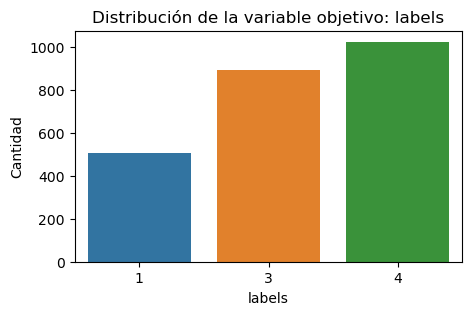

,conteo,porcentaje
4,1025,42.29
3,894,36.88
1,505,20.83


In [3]:
# visualizar balanceo de la variable objetivo
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

# mostrar conteo del balanceo de la variable objetivo
dist = df["labels"].value_counts(dropna=False)
tb_dist = pd.DataFrame({"conteo": dist, "porcentaje": (dist/dist.sum()*100).round(2)})
display(tb_dist)

La distribución de la variable objetivo refleja un desbalance: los ODS 4 y 3 concentran la mayoría de los registros, mientras que el ODS 1 tiene una representación menor. Esta diferencia puede dificultar el entrenamiento equilibrado de los modelos y afectar la capacidad de clasificar correctamente las opiniones vinculadas con pobreza. Como en esta etapa no se contempla la opción de aumentar datos, el desbalance se mantiene, pero en furturas se espera balancear los datos.


## 2.2. Entendimiento de la variable explicativa

En el análisis de la variable textos resulta relevante observar la longitud de las opiniones, ya que si son demasiado cortas pueden aportar poca información y si son muy largas pueden introducir ruido. Revisar este aspecto permite anticipar posibles dificultades al momento de entrenar el modelo.


No resulta prioritario enfocarse en patrones específicos como enlaces o expresiones puntuales, porque podrían generar fuga de datos y, además, la vectorización que se vaya a seleccionar puede encargarse de considerar este tipo de aspectos.


Estadísticas descriptivas de la longitud del texto:


,len_palabras,len_caracteres
count,2424.00,2424.00
mean,107.92,683.22
std,35.58,223.56
min,41.00,303.00
25%,81.00,513.00
50%,102.00,647.00
75%,129.00,809.25
95%,177.00,1112.85
max,260.00,1492.00



Histograma de la longitud del texto:


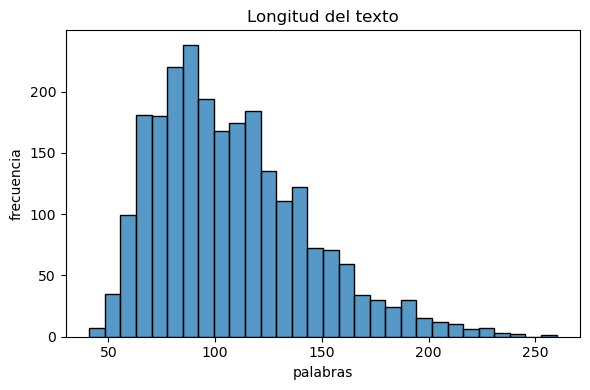

In [4]:
# longitud de palabras y caracteres de los textos
len_palabras   = df["textos"].astype(str).str.split().str.len()
len_caracteres = df["textos"].astype(str).str.len()

df_longitud = pd.DataFrame({
    "len_palabras": len_palabras,
    "len_caracteres": len_caracteres
})

# estadisticas descriptivas
print("\nEstadísticas descriptivas de la longitud del texto:")
stats = df_longitud[["len_palabras","len_caracteres"]].describe(percentiles=[.25,.5,.75,.95]).round(2)
display(stats)

# histograma longitud de palabras
print("\nHistograma de la longitud del texto:")
plt.figure(figsize=(6,4))
sns.histplot(df_longitud["len_palabras"], bins=30, kde=False)
plt.title("Longitud del texto")
plt.xlabel("palabras"); plt.ylabel("frecuencia")
plt.tight_layout(); plt.show()

La longitud de los textos presenta una distribución similar a una normal con ligera cola hacia la derecha. En general, la mayoría de las opiniones se concentran entre 60 y 120 palabras, lo que refleja una extensión adecuada y consistente de los datos para el entrenamiento.

# 3. Preparacion de los datos

En la etapa de preparación de los datos se revisará la unicidad, completitud, validez y consistencia para asegurar la calidad de la información. Además, se realizará la división en conjuntos de entrenamiento, prueba y validación, y se seleccionará un tipo de vectorización que permita ingresar los textos a los modelos de clasificación.

## 3.1. Unicidad

In [5]:
# revisamos que no haya filas duplicadas
print("Filas antes de eliminar duplicados:", df.shape[0])
df = df.drop_duplicates()
print("Filas después de eliminar duplicados:", df.shape[0])

Filas antes de eliminar duplicados: 2424
Filas después de eliminar duplicados: 2424


No se identificaron textos duplicados.


## 3.2. Completitud


In [6]:
# revisamos que no haya valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nFilas antes de eliminar filas con valores faltantes:", df.shape[0])
df = df.dropna()
print("Filas después de eliminar filas con valores faltantes:", df.shape[0])


Valores nulos por columna:
textos    0
labels    0
dtype: int64

Filas antes de eliminar filas con valores faltantes: 2424
Filas después de eliminar filas con valores faltantes: 2424


No se identificaron valores nulos en las columnas.

## 3.3. Validez y consistencia

En la validez y consistencia es relevante comprobar que no existan textos iguales con etiquetas distintas ni textos vacíos, porque estas situaciones pueden generar confusión en el entrenamiento del modelo y afectar la calidad de los resultados.

In [7]:
# revisamos que no haya textos vacios
texto_vacio = df["textos"].astype("string").str.strip().eq("")
print("Textos vacíos encontrados:", int(texto_vacio.sum()))

print("\nFilas antes de eliminar filas con textos vacíos:", df.shape[0])
df = df[~texto_vacio]
print("Filas después de eliminar filas con textos vacíos:", df.shape[0])

# revisamos que no haya textos iguales
dup_texto = df.duplicated(subset=["textos"]).sum()
print("\nTextos duplicados encontrados:", int(dup_texto))

print("\nFilas antes de eliminar duplicados:", df.shape[0])
df = df.drop_duplicates(subset=["textos"], keep="first").reset_index(drop=True)
print("Filas después de eliminar duplicados:", df.shape[0])

Textos vacíos encontrados: 0

Filas antes de eliminar filas con textos vacíos: 2424
Filas después de eliminar filas con textos vacíos: 2424

Textos duplicados encontrados: 0

Filas antes de eliminar duplicados: 2424
Filas después de eliminar duplicados: 2424


No se identificaron textos iguales con etiquetas distintas ni textos vacíos.

## 3.4. Division datos train, test y validacion

Se realizó la división del dataset en 70 % para entrenamiento, 20 % para validación y 10 % para prueba. El conjunto de validación se emplea para la selección de modelos, mientras que el de prueba se reserva para calcular las métricas finales del modelo escogido y evitar sobreajuste.

In [8]:
from sklearn.model_selection import train_test_split

# division de los datos en train, test y validacion
X = df["textos"]
y = df["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=2/3, stratify=y_test, random_state=0)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])
print("Tamaño del conjunto de validacion:", X_valid.shape[0])

Tamaño del conjunto de entrenamiento: 1696
Tamaño del conjunto de prueba: 486
Tamaño del conjunto de validacion: 242


## 3.5. Vectorizacion de los datos

Para representar los textos se utilizó la vectorización TF-IDF, dado que permite reflejar no solo la frecuencia de las palabras, sino también su importancia relativa dentro del conjunto de documentos. Frente a un conteo simple de términos, TF-IDF reduce el peso de palabras demasiado comunes y resalta aquellas que aportan mayor capacidad de discriminación para la clasificación.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizacion de los datos con tf-idf
vectorizador = TfidfVectorizer(
    ngram_range=(1,2),       # usar unigramas y bigramas
    min_df=0.01,             # descartar términos que aparezcan en menos del 1% de las filas
    max_df=0.80,             # descartar términos que aparezcan en más del 80% de filas
    strip_accents='unicode', # normalizar acentos: "educación" → "educacion"
    sublinear_tf=True        # aplicar escala logarítmica a la frecuencia de términos
)

# train, test y validacion vectorizados
X_train_vec = vectorizador.fit_transform(X_train)
X_test_vec  = vectorizador.transform(X_test)
X_valid_vec = vectorizador.transform(X_valid)

print("Tamaño del vocabulario:", len(vectorizador.vocabulary_))
print("Tamaño del conjunto de entrenamiento:", X_train_vec.shape)
print("Tamaño del conjunto de prueba:", X_test_vec.shape)
print("Tamaño del conjunto de validacion:", X_valid_vec.shape)

Tamaño del vocabulario: 2132
Tamaño del conjunto de entrenamiento: (1696, 2132)
Tamaño del conjunto de prueba: (486, 2132)
Tamaño del conjunto de validacion: (242, 2132)


Se definieron parámetros específicos para mejorar la calidad de las representaciones: se incluyeron unigramas y bigramas (ngram_range=(1,2)) con el fin de capturar tanto palabras individuales como combinaciones frecuentes de dos términos; se descartaron los términos muy poco frecuentes (min_df=0.01) y los excesivamente repetidos (max_df=0.80) para evitar ruido y sesgos; se normalizaron los acentos (strip_accents='unicode') para unificar la escritura de las palabras; y se aplicó la transformación sublineal (sublinear_tf=True) para atenuar el efecto de palabras que aparecen muchas veces en un mismo texto. Estas decisiones buscan construir un espacio de características más robusto y adecuado para entrenar los modelos de clasificación.

# 4. Entrenamiento de los modelos

En el entrenamiento de modelos se busca que cada integrante del grupo proponga dos modelos que se ajusten bien a la tarea de clasificación de textos. Cada uno de ellos se entrena con los datos de entrenamiento y luego se evalúa con el conjunto de prueba, de donde se seleccionan los tres con mejor desempeño. Posteriormente, estos tres modelos se vuelven a evaluar con los datos de validación y a partir de ese resultado se elige el mejor. Este procedimiento se realizó con el propósito de evitar el sobreajuste y no depender únicamente de los datos de prueba, sino contar con dos etapas de contraste que permitan identificar el modelo que se comporta de manera más consistente.

## 4.1. Seleccion modelos

### 4.1.1. Modelos Juan Pablo Reyes

La regresión logística es un modelo de clasificación que estima la probabilidad de que un texto pertenezca a una categoría a partir de sus características. Aunque su nombre hace referencia a la regresión, en realidad funciona como un clasificador lineal que utiliza la función sigmoide para transformar los resultados en probabilidades y asignar la clase con mayor valor. Se eligió este modelo porque es una técnica robusta, interpretativa y ampliamente usada en problemas de clasificación de textos, especialmente cuando se trabaja con representaciones como TF-IDF.


En cuanto a los parámetros, se aumentó el número máximo de iteraciones (max_iter=2000) para asegurar la convergencia del algoritmo. Además, se activó la opción de balanceo de clases (class_weight="balanced") con el fin de compensar las diferencias en la cantidad de ejemplos por categoría, reduciendo el sesgo hacia las clases mayoritarias y mejorando el desempeño en las minoritarias.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# entrenamiento del modelo
modelo_rl = LogisticRegression(max_iter=2000, class_weight="balanced")
modelo_rl.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

LinearSVC es un modelo de clasificación que implementa un soporte vectorial lineal. Su funcionamiento se basa en encontrar un hiperplano que separe de la mejor manera posible las clases en el espacio de características. En problemas de clasificación de textos, donde los datos suelen tener alta dimensionalidad por la vectorización, este tipo de modelo resulta muy eficiente, ya que maneja bien grandes volúmenes de atributos y logra fronteras de decisión claras entre categorías.


En cuanto a los parámetros, se activó el balanceo de clases (class_weight="balanced") para compensar la diferencia en el número de ejemplos por categoría, evitando que el modelo se incline hacia las clases mayoritarias. Además, se fijó el valor de C=1.0, que controla la regularización: valores más bajos de C implican mayor penalización a los errores y modelos más simples, mientras que valores más altos permiten que el modelo se ajuste más a los datos de entrenamiento. Con C=1.0 se busca un equilibrio entre generalización y ajuste.


In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# entrenamiento del modelo
modelo_svm = LinearSVC(class_weight="balanced", C=1.0)
modelo_svm.fit(X_train_vec, y_train)

LinearSVC(class_weight='balanced')

### 4.1.2. Modelos Juan Diego Rodriguez

SGDClassifier es un clasificador lineal que utiliza el método de descenso de gradiente estocástico para optimizar sus parámetros. En lugar de procesar todo el conjunto de datos a la vez, actualiza los coeficientes de manera incremental, lo que lo hace muy eficiente para problemas con grandes volúmenes de características, como ocurre en la clasificación de textos con TF-IDF.

Respecto a los parámetros, se estableció loss="log_loss" para que el modelo entrene como una regresión logística y pueda producir probabilidades asociadas a cada clase. Se activó class_weight="balanced" con el fin de compensar el desbalance de clases en el dataset. El valor de alpha=1e-4 se fijó como término de regularización para evitar sobreajuste manteniendo al mismo tiempo un buen ajuste al entrenamiento. Se aumentó max_iter=2000 para dar más iteraciones al algoritmo y asegurar la convergencia. Finalmente, se definió random_state=0 para garantizar la reproducibilidad de los resultados.


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# entrenamiento del modelo
modelo_sgd = SGDClassifier(loss="log_loss", class_weight="balanced", alpha=1e-4, max_iter=2000, random_state=0)
modelo_sgd.fit(X_train_vec, y_train)

ValueError: The loss log_loss is not supported. 

RidgeClassifier es un modelo lineal de clasificación que aplica una regularización de tipo L2 sobre los coeficientes. Su funcionamiento consiste en encontrar una frontera de decisión lineal que separe las clases, pero penalizando los pesos muy grandes para evitar sobreajuste. Este tipo de clasificador es especialmente útil en problemas de alta dimensionalidad como la clasificación de textos, ya que ayuda a mantener la estabilidad del modelo cuando hay muchos atributos.

Respecto a los parámetros, se utilizó class_weight="balanced" para compensar las diferencias en la cantidad de ejemplos de cada clase y evitar que el modelo favorezca a las categorías mayoritarias. También se definió random_state=0 con el fin de asegurar la reproducibilidad de los resultados.


In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# entrenamiento del modelo
modelo_ridge = RidgeClassifier(class_weight="balanced", random_state=0)
modelo_ridge.fit(X_train_vec, y_train)

RidgeClassifier(class_weight='balanced', random_state=0)

### 4.1.3 Modelos Santiago Pineda

El modelo parte de un LinearSVC, que es un clasificador lineal basado en máquinas de soporte vectorial, y lo envuelve en un CalibratedClassifierCV. Esta calibración permite que, además de predecir las clases, el modelo genere probabilidades ajustadas a través del método isotonic. Esto es relevante porque LinearSVC por sí solo no produce probabilidades, y disponer de ellas facilita tanto la interpretación de los resultados como el uso en métricas que dependen de probabilidades.


Se utilizó class_weight="balanced" en la base LinearSVC para compensar el desbalance de clases y se fijó C=1.0 para mantener un nivel de regularización intermedio. Además, se estableció random_state=0 para garantizar la reproducibilidad de los resultados. En la calibración, se eligió el método isotonic porque produce estimaciones de probabilidad más flexibles, y se aplicó validación cruzada con cv=5 para asegurar que la calibración sea estable y generalizable.


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# entrenamiento del modelo
base_svm = LinearSVC(class_weight="balanced", C=1.0, random_state=0)
modelo_svm_cal = CalibratedClassifierCV(base_svm, method="isotonic", cv=5)
modelo_svm_cal.fit(X_train_vec, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=LinearSVC(class_weight='balanced',
                                           random_state=0),
                       method='isotonic')

ComplementNB es una variante del clasificador Naive Bayes diseñada específicamente para trabajar mejor con datos desbalanceados y representaciones de texto como TF-IDF. Su lógica se basa en el principio de independencia condicional entre las características, calculando la probabilidad de que un texto pertenezca a cada clase y asignando aquella con mayor probabilidad. Al estar ajustado para manejar mejor las clases minoritarias, suele ser más estable que el Naive Bayes multinomial estándar en problemas de clasificación de textos.


En este caso se utilizó alpha=1.0, que corresponde al parámetro de suavizado de Laplace. Este suavizado evita problemas cuando aparecen palabras que no estaban en el entrenamiento, reduciendo la posibilidad de que el modelo asigne probabilidad cero a nuevas observaciones. Con este valor se mantiene un balance adecuado entre generalización y ajuste a los datos de entrenamiento.


In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# entrenamiento del modelo
modelo_cnb = ComplementNB(alpha=1.0)
modelo_cnb.fit(X_train_vec, y_train)

ComplementNB()

## 4.2. Evaluacion de los modelos con test

Test:



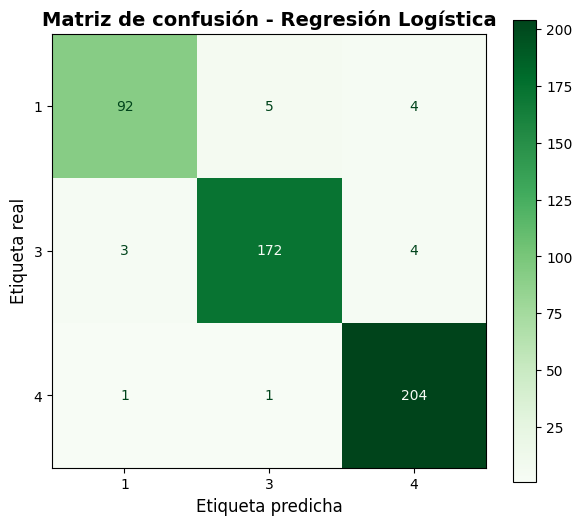


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9583    0.9109    0.9340       101
           3     0.9663    0.9609    0.9636       179
           4     0.9623    0.9903    0.9761       206

    accuracy                         0.9630       486
   macro avg     0.9623    0.9540    0.9579       486
weighted avg     0.9629    0.9630    0.9627       486



In [ ]:
y_test_rl = modelo_rl.predict(X_test_vec)

# test
print("Test:\n")

# matriz de confusion test
cm = confusion_matrix(y_test, y_test_rl, labels=modelo_rl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_rl.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Greens", ax=ax, values_format="d")
plt.title("Matriz de confusión - Regresión Logística", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha", fontsize=12)
plt.ylabel("Etiqueta real", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_rl, digits=4))

El modelo de regresión logística presenta un desempeño destacado al alcanzar un f1 macro de 0.958, lo que indica un equilibrio sólido entre precisión y recall en las tres clases. La clase 4 sobresale por su alta cobertura y consistencia, la clase 3 mantiene métricas muy estables y la clase 1, aunque muestra algo más de confusión frente a las demás, conserva un f1 superior a 0.93. En general, el modelo ofrece resultados homogéneos y confiables, sin diferencias marcadas entre categorías, lo que respalda su idoneidad para la tarea de clasificación de textos en ODS.

Test:



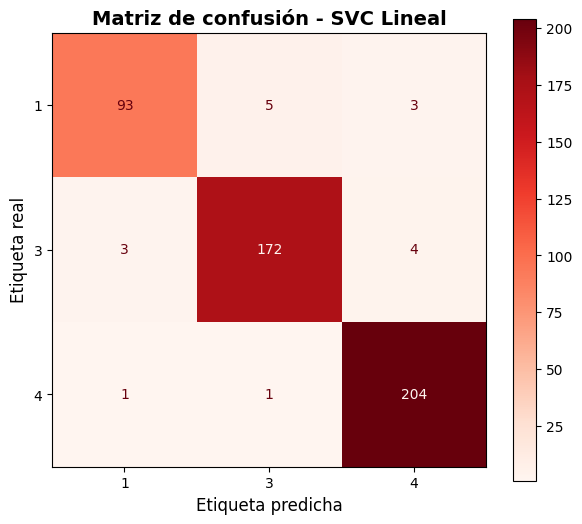


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9588    0.9208    0.9394       101
           3     0.9663    0.9609    0.9636       179
           4     0.9668    0.9903    0.9784       206

    accuracy                         0.9650       486
   macro avg     0.9640    0.9573    0.9605       486
weighted avg     0.9650    0.9650    0.9648       486



In [ ]:
y_test_svm = modelo_svm.predict(X_test_vec)

# test
print("Test:\n")

# matriz de confusion test
cm = confusion_matrix(y_test, y_test_svm, labels=modelo_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_svm.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Reds", ax=ax, values_format="d")
plt.title("Matriz de confusión - SVC Lineal", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha", fontsize=12)
plt.ylabel("Etiqueta real", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_svm, digits=4))

El modelo SVC lineal ofrece un desempeño consistente con un f1 macro de 0.9605, mostrando equilibrio entre precisión y recall en las tres clases. La clase 4 presenta el mejor comportamiento con f1 de 0.9784 y cobertura casi total, la clase 3 mantiene un f1 de 0.9636 con errores muy acotados, y la clase 1 alcanza un f1 de 0.9394 con algo más de confusión hacia 3 y 4. En conjunto, los resultados son homogéneos y confiables, con diferencias pequeñas entre categorías, lo que respalda su solidez para la clasificación de los textos en ODS.

Test:



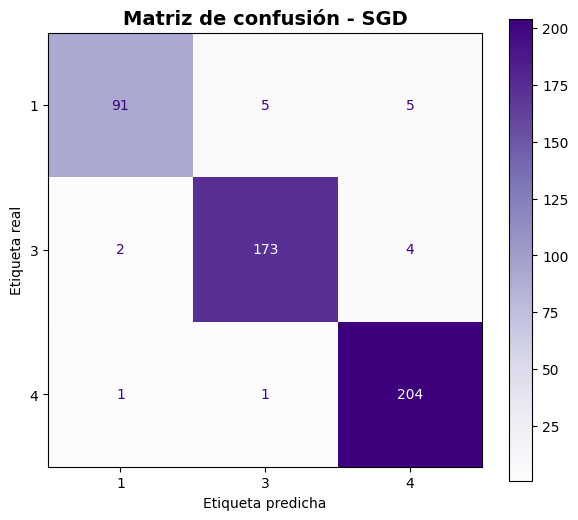


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9681    0.9010    0.9333       101
           3     0.9665    0.9665    0.9665       179
           4     0.9577    0.9903    0.9737       206

    accuracy                         0.9630       486
   macro avg     0.9641    0.9526    0.9579       486
weighted avg     0.9631    0.9630    0.9627       486



In [ ]:
y_test_sgd = modelo_sgd.predict(X_test_vec)

# test
print("Test:\n")

# matriz de confusion test
cm = confusion_matrix(y_test, y_test_sgd, labels=modelo_sgd.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_sgd.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Purples", ax=ax, values_format="d")
plt.title("Matriz de confusión - SGD", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha"); plt.ylabel("Etiqueta real"); plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_sgd, digits=4))

El modelo SGD ofrece un desempeño consistente con un f1 macro de 0.9579, lo que indica buen equilibrio entre precisión y recall. La clase 4 destaca con f1 de 0.9737 y una cobertura muy alta, la clase 3 se mantiene estable con f1 de 0.9665, y la clase 1 es la más exigente con f1 de 0.9333 debido a un recall algo menor (0.9010). En conjunto, las métricas son parejas entre categorías y reflejan una clasificación sólida.

Test:



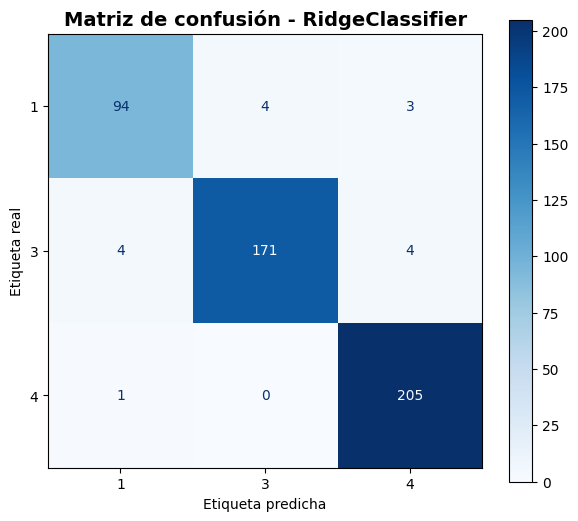


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9495    0.9307    0.9400       101
           3     0.9771    0.9553    0.9661       179
           4     0.9670    0.9951    0.9809       206

    accuracy                         0.9671       486
   macro avg     0.9645    0.9604    0.9623       486
weighted avg     0.9671    0.9671    0.9669       486



In [ ]:
y_test_ridge = modelo_ridge.predict(X_test_vec)

# test
print("Test:\n")

# matriz de confusion test
cm = confusion_matrix(y_test, y_test_ridge, labels=modelo_ridge.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_ridge.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Matriz de confusión - RidgeClassifier", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha"); plt.ylabel("Etiqueta real"); plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_ridge, digits=4))

El modelo RidgeClassifier presenta un f1 macro de 0.9623, con métricas parejas entre clases. La clase 4 destaca con f1 de 0.9809 y alta cobertura, la clase 3 mantiene un f1 de 0.9661 con errores acotados, y la clase 1 logra un f1 de 0.9400 con algo más de confusión relativa. En conjunto, el rendimiento es estable y consistente, sin diferencias marcadas entre categorías.

Test:



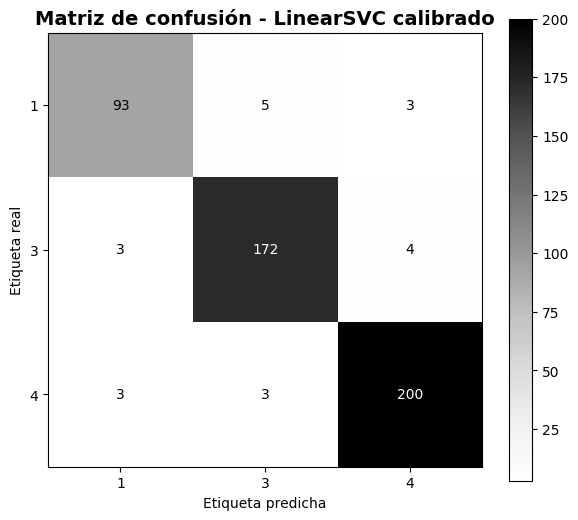


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9394    0.9208    0.9300       101
           3     0.9556    0.9609    0.9582       179
           4     0.9662    0.9709    0.9685       206

    accuracy                         0.9568       486
   macro avg     0.9537    0.9509    0.9522       486
weighted avg     0.9567    0.9568    0.9567       486



In [ ]:
y_test_svm_cal = modelo_svm_cal.predict(X_test_vec)

# test
print("Test:\n")

# matriz de confusion test
cm = confusion_matrix(y_test, y_test_svm_cal, labels=modelo_svm_cal.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_svm_cal.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Greys", ax=ax, values_format="d")
plt.title("Matriz de confusión - LinearSVC calibrado", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha"); plt.ylabel("Etiqueta real"); plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_svm_cal, digits=4))

El modelo LinearSVC calibrado alcanza un f1 macro de 0.9522, con resultados parejos entre clases. La clase 4 presenta el mejor desempeño con f1 de 0.9685 y alta cobertura; la clase 3 mantiene un f1 de 0.9582 con errores acotados; y la clase 1, aunque algo más exigente, se sitúa en f1 de 0.9300. En conjunto, el comportamiento es consistente y estable, con diferencias moderadas entre categorías.

Test:



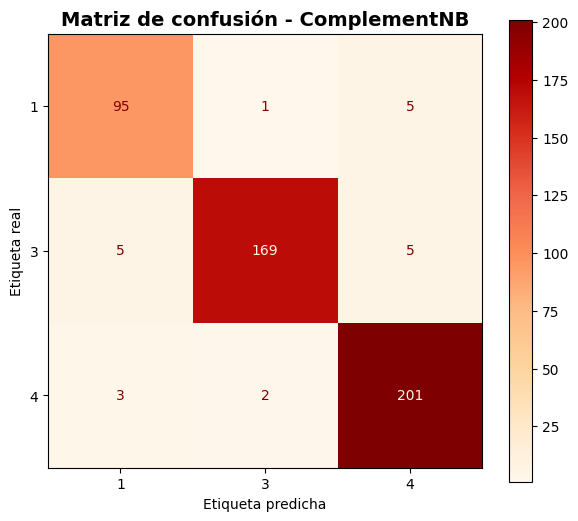


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9223    0.9406    0.9314       101
           3     0.9826    0.9441    0.9630       179
           4     0.9526    0.9757    0.9640       206

    accuracy                         0.9568       486
   macro avg     0.9525    0.9535    0.9528       486
weighted avg     0.9573    0.9568    0.9568       486



In [ ]:
y_test_cnb = modelo_cnb.predict(X_test_vec)

# test
print("Test:\n")

# matriz de confusion test
cm = confusion_matrix(y_test, y_test_cnb, labels=modelo_cnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_cnb.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="OrRd", ax=ax, values_format="d")
plt.title("Matriz de confusión - ComplementNB", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha"); plt.ylabel("Etiqueta real"); plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_test, y_test_cnb, digits=4))

ComplementNB alcanza un f1 macro de 0.9528, con resultados equilibrados entre clases. La clase 3 y la 4 se mantienen en niveles altos de f1 (0.9630 y 0.9640), con errores contenidos; la clase 1 logra un f1 de 0.9314 y muestra un comportamiento estable. En conjunto, el modelo ofrece métricas parejas y un patrón de confusiones moderado, consistente con un desempeño sólido en la clasificación de los textos.

## 4.3. Seleccion de los mejores modelos

Se observa que todos los modelos alcanzaron métricas muy consistentes con los datos de prueba, sin grandes diferencias en su capacidad de clasificación. Para la selección resulta más adecuado priorizar el f1-score macro, ya que ofrece una medida equilibrada entre precisión y recall en cada clase, asegurando que el desempeño sea estable en todas las categorías de los ODS. En caso de empate en el f1-score macro, se decidió utilizar el recall macro como criterio de desempate, dado que este refleja la capacidad del modelo de identificar la mayor cantidad de instancias relevantes, lo cual es clave en un problema como este, donde no queremos dejar por fuera opiniones de la ciudadanía que se relacionen con los ODS priorizados

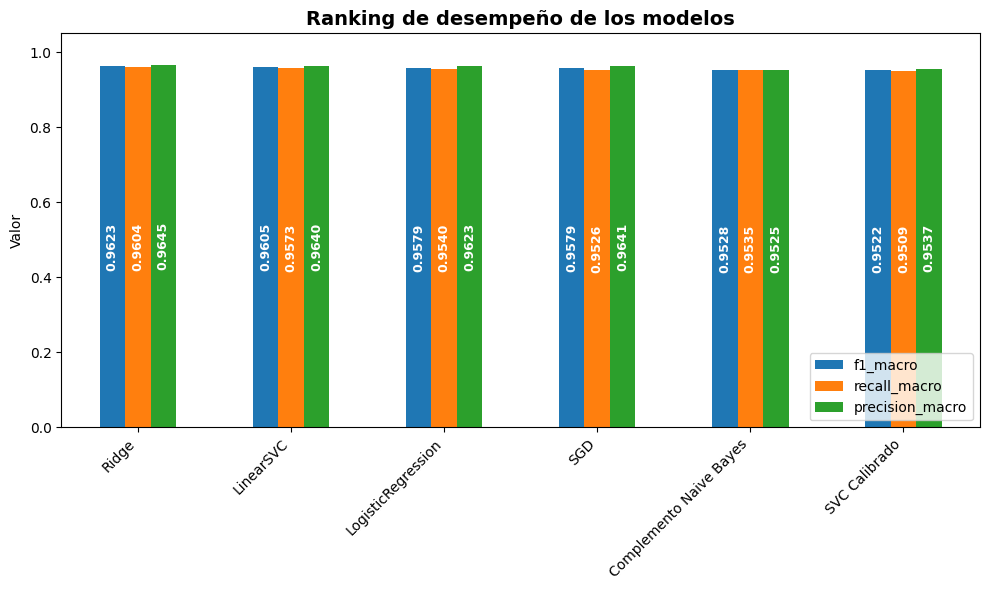

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def get_metrics(y_true, y_pred):
    return {
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred),
    }

# Calcular métricas test para cada modelo
resultados = {}
for nombre, mdl in {
    "LogisticRegression": modelo_rl,
    "LinearSVC": modelo_svm,
    "SGD": modelo_sgd,
    "Ridge": modelo_ridge,
    "SVC Calibrado": modelo_svm_cal,
    "Complemento Naive Bayes": modelo_cnb
}.items():
    y_pred = mdl.predict(X_test_vec)
    resultados[nombre] = get_metrics(y_test, y_pred)

df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.sort_values(by="f1_macro", ascending=False)
df_plot = df_resultados[["f1_macro", "recall_macro", "precision_macro"]]

colores = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Graficar
ax = df_plot.plot(
    kind="bar",
    figsize=(10,6),
    color=colores
)
plt.title("Ranking de desempeño de los modelos", fontsize=14, weight="bold")
plt.ylabel("Valor")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1.05)
plt.legend(loc="lower right")

for p in ax.patches:
    value = p.get_height()
    x = p.get_x() + p.get_width()/2
    y = value / 2
    ax.annotate(
        f"{value:.4f}",
        (x, y),
        ha='center', va='center', fontsize=9,
        color="white", weight="bold", rotation=90
    )

plt.tight_layout()
plt.show()

Dado los criterios definidos y los resultados obtenidos en los datos de prueba, se seleccionaron como mejores modelos Ridge, LinearSVC y LogisticRegression, al ubicarse en las tres primeras posiciones del ranking con los valores más altos de f1-score macro.

## 4.4. Evaluacion de los modelos con validacion


Validacion:



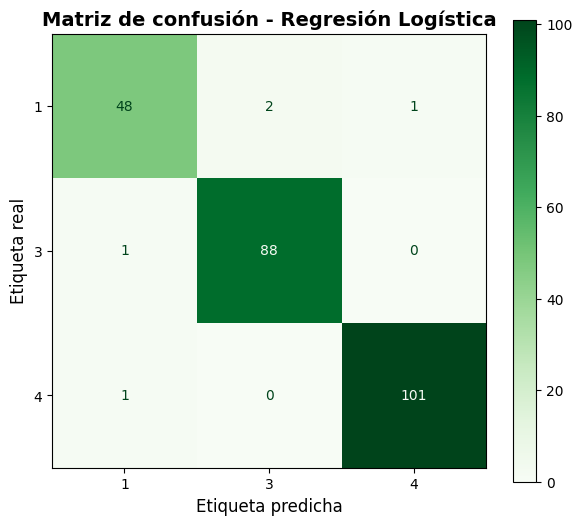


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9600    0.9412    0.9505        51
           3     0.9778    0.9888    0.9832        89
           4     0.9902    0.9902    0.9902       102

    accuracy                         0.9793       242
   macro avg     0.9760    0.9734    0.9746       242
weighted avg     0.9793    0.9793    0.9793       242



In [ ]:
y_valid_rl = modelo_rl.predict(X_valid_vec)

# validacion
print("\nValidacion:\n")

# matriz de confusion validacion
cm = confusion_matrix(y_valid, y_valid_rl, labels=modelo_rl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_rl.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Greens", ax=ax, values_format="d")
plt.title("Matriz de confusión - Regresión Logística", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha", fontsize=12)
plt.ylabel("Etiqueta real", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()

# metricas validscion
print("\nReporte de clasificación:")
print(classification_report(y_valid, y_valid_rl, digits=4))

En validación, la regresión logística mejora frente a prueba: f1 macro 0.9746 vs 0.9579 y recall macro 0.9734 vs 0.9540 (precision macro 0.9760 vs 0.9623). Por clase, ODS 1 sube su f1 de 0.9340 a 0.9505 y el recall de 0.9109 a 0.9412; ODS 3 pasa de f1 0.9636 a 0.9832 y recall de 0.9609 a 0.9888; ODS 4 se mantiene muy alto, con f1 de 0.9761 a 0.9902 y recall prácticamente igual (~0.99). En conjunto, el comportamiento es consistente y ligeramente mejor en validación, lo que respalda la estabilidad del modelo sin depender de una sola categoría.


Validacion:



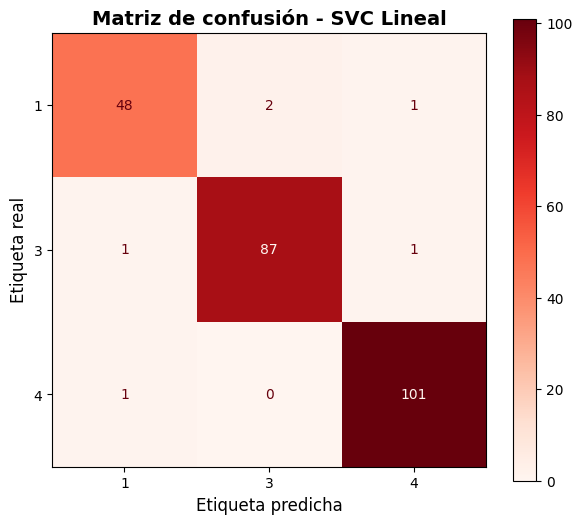


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9600    0.9412    0.9505        51
           3     0.9775    0.9775    0.9775        89
           4     0.9806    0.9902    0.9854       102

    accuracy                         0.9752       242
   macro avg     0.9727    0.9696    0.9711       242
weighted avg     0.9751    0.9752    0.9751       242



In [ ]:
y_valid_svm = modelo_svm.predict(X_valid_vec)

# validacion
print("\nValidacion:\n")

# matriz de confusion validacion
cm = confusion_matrix(y_valid, y_valid_svm, labels=modelo_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_svm.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Reds", ax=ax, values_format="d")
plt.title("Matriz de confusión - SVC Lineal", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha", fontsize=12)
plt.ylabel("Etiqueta real", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_valid, y_valid_svm, digits=4))

En validación, el modelo LinearSVC mantiene un f1 macro de 0.9711, muy cercano al obtenido en prueba (0.9605). La clase 4 alcanza un f1 de 0.9854 frente al 0.9784 en prueba, lo que confirma un comportamiento estable y consistente. La clase 3 se sostiene con un f1 de 0.9775, ligeramente superior al 0.9636 en prueba, mientras que la clase 1 logra un f1 de 0.9505, también mejor que el 0.9394 alcanzado en prueba. En conjunto, se observa que el modelo no solo mantiene métricas homogéneas, sino que incluso mejora sus resultados al evaluarse en validación, lo que refuerza su solidez para la clasificación de textos en los ODS.


Validacion:



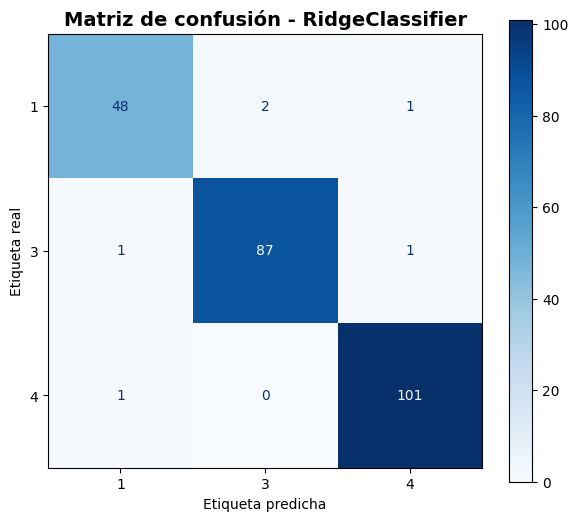


Reporte de clasificación:
              precision    recall  f1-score   support

           1     0.9600    0.9412    0.9505        51
           3     0.9775    0.9775    0.9775        89
           4     0.9806    0.9902    0.9854       102

    accuracy                         0.9752       242
   macro avg     0.9727    0.9696    0.9711       242
weighted avg     0.9751    0.9752    0.9751       242



In [ ]:
y_valid_ridge = modelo_ridge.predict(X_valid_vec)

# validacion
print("\nValidacion:\n")

# matriz de confusion validacion
cm = confusion_matrix(y_valid, y_valid_ridge, labels=modelo_ridge.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_ridge.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Matriz de confusión - RidgeClassifier", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha"); plt.ylabel("Etiqueta real"); plt.grid(False)
plt.show()

# metricas test
print("\nReporte de clasificación:")
print(classification_report(y_valid, y_valid_ridge, digits=4))

En validación, el modelo RidgeClassifier alcanza un f1 macro de 0.9711, mostrando una mejora respecto al obtenido en prueba (0.9623). La clase 4 registra un f1 de 0.9854 frente al 0.9809 en prueba, consolidando su alta capacidad de clasificación. La clase 3 se mantiene muy consistente, con un f1 de 0.9775, superior al 0.9661 anterior, mientras que la clase 1 logra un f1 de 0.9505, también por encima del 0.9400 obtenido en prueba. En conjunto, los resultados confirman que el modelo conserva métricas homogéneas y refuerza su desempeño al evaluarse en validación, evidenciando estabilidad y solidez en la clasificación de los textos.

## 4.5. Seleccion del modelo final

Se observa que todos los modelos alcanzaron métricas muy consistentes con los datos de prueba, sin grandes diferencias en su capacidad de clasificación. Para la selección final resulta más adecuado priorizar el f1-score macro, ya que ofrece una medida equilibrada entre precisión y recall en cada clase, asegurando que el desempeño sea estable en todas las categorías de los ODS. En caso de empate en el f1-score macro, se decidió utilizar el recall macro como criterio de desempate, dado que este refleja la capacidad del modelo de identificar la mayor cantidad de instancias relevantes, lo cual es clave en un problema como este, donde no queremos dejar por fuera opiniones de la ciudadanía que se relacionen con los ODS priorizados

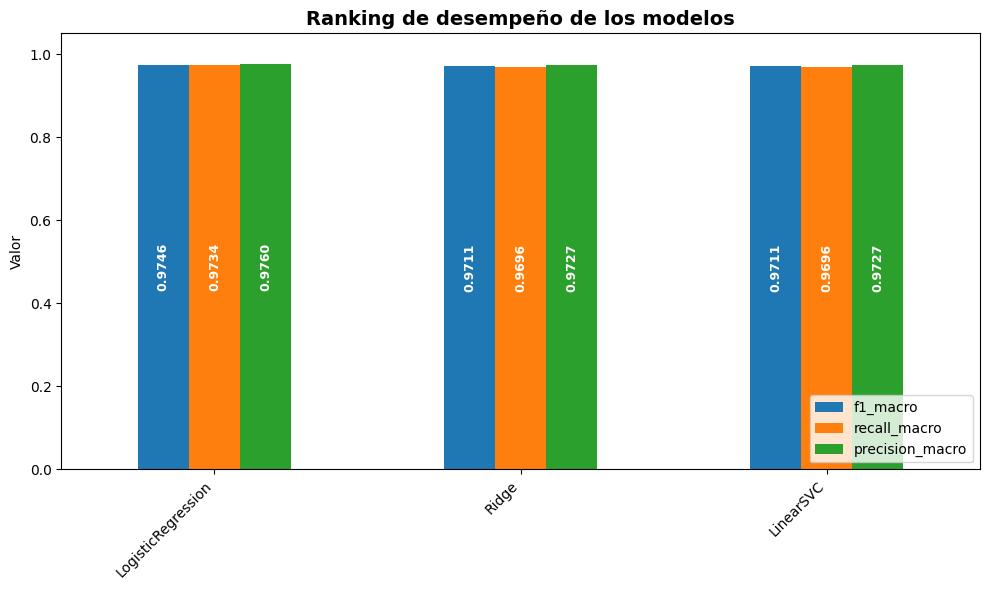

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def get_metrics(y_true, y_pred):
    return {
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred),
    }

# calculo métricas validacion para cada modelo
resultados = {}
for nombre, mdl in {
    "Ridge": modelo_ridge,
    "LogisticRegression": modelo_rl,
    "LinearSVC": modelo_svm
}.items():
    y_pred = mdl.predict(X_valid_vec)
    resultados[nombre] = get_metrics(y_valid, y_pred)

df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.sort_values(by="f1_macro", ascending=False)
df_plot = df_resultados[["f1_macro", "recall_macro", "precision_macro"]]

colores = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# grafica
ax = df_plot.plot(
    kind="bar",
    figsize=(10,6),
    color=colores
)
plt.title("Ranking de desempeño de los modelos", fontsize=14, weight="bold")
plt.ylabel("Valor")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1.05)
plt.legend(loc="lower right")

for p in ax.patches:
    value = p.get_height()
    x = p.get_x() + p.get_width()/2
    y = value / 2
    ax.annotate(
        f"{value:.4f}",
        (x, y),
        ha='center', va='center', fontsize=9,
        color="white", weight="bold", rotation=90
    )

plt.tight_layout()
plt.show()

Se seleccionó el modelo de regresión logística por alcanzar el mejor equilibrio en las métricas, destacando un f1 macro superior y un desempeño consistente en validación frente a prueba.

# 5. Resultados del modelo escogido

En resultados se presentan las métricas de desempeño, las curvas ROC y AUC, así como las palabras más importantes asociadas a cada clase de ODS, considerando el modelo seleccionado de regresión logística y tomando como referencia los datos de validación.

## 5.1. Metricas

In [21]:
# matriz de confusion validacion
cm = confusion_matrix(y_valid, y_valid_rl, labels=modelo_rl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_rl.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap="Greens", ax=ax, values_format="d")
plt.title("Matriz de confusión - Regresión Logística", fontsize=14, weight="bold")
plt.xlabel("Etiqueta predicha", fontsize=12)
plt.ylabel("Etiqueta real", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()

# metricas validscion
print("\nReporte de clasificación:")
print(classification_report(y_valid, y_valid_rl, digits=4))

NameError: name 'y_valid_rl' is not defined

El modelo de regresión logística cierra con un desempeño muy sólido en validación: f1 macro de 0.9746, con resultados altos y parejos por clase. La clase 4 alcanza f1 de 0.9902 con mínimos errores; la clase 3 llega a 0.9832 con cobertura cercana al total; y la clase 1 mantiene un f1 de 0.9505 con muy pocas confusiones. La matriz de confusión confirma que la mayor parte de los casos se clasifican correctamente en su categoría, con off-diagonales reducidas. En conjunto, el modelo muestra estabilidad y capacidad de generalización, cumpliendo adecuadamente el objetivo de clasificar los textos en los ODS definidos. Este nivel de desempeño aporta a los objetivos del negocio porque asegura que las opiniones ciudadanas se asignen correctamente al ODS correspondiente, lo que permite diseñar estrategias precisas y basadas en evidencia en torno a pobreza, salud y educación.

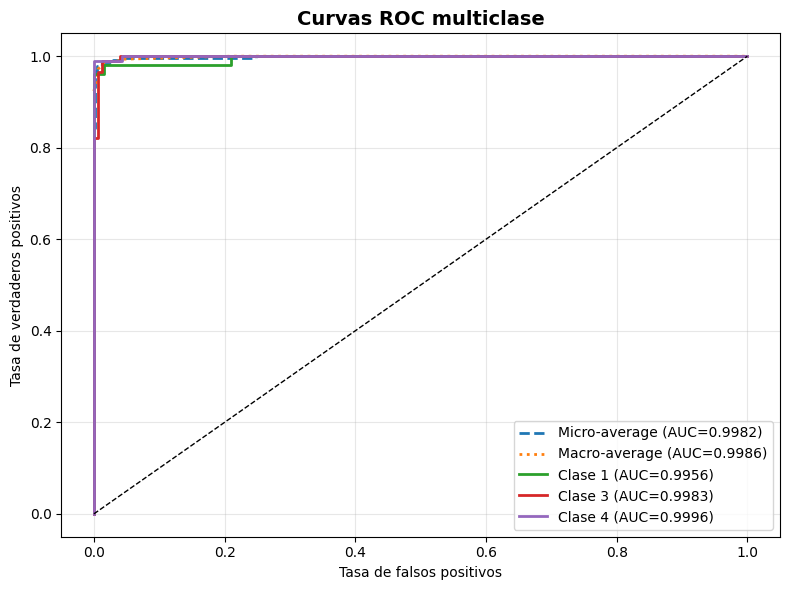

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# probabilidades del modelo
y_score = modelo_rl.predict_proba(X_valid_vec)
classes = modelo_rl.classes_
y_test_bin = label_binarize(y_valid, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# gráfica
plt.figure(figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"], lw=2, linestyle="--",
         label=f'Micro-average (AUC={roc_auc["micro"]:.4f})')
plt.plot(fpr["macro"], tpr["macro"], lw=2, linestyle=":",
         label=f'Macro-average (AUC={roc_auc["macro"]:.4f})')

for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {cls} (AUC={roc_auc[i]:.4f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC multiclase', fontsize=14, weight="bold")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Las curvas ROC multiclase muestran que el modelo de regresión logística tiene un desempeño sobresaliente, con valores AUC cercanos a 1 tanto en el promedio micro (0.9982) como en el macro (0.9986), además de resultados muy altos en cada clase de forma individual. Esto refleja que el modelo logra distinguir de manera consistente entre las clases, manteniendo tasas de verdaderos positivos muy elevadas con mínimos falsos positivos. En conjunto con las métricas previas, estos resultados confirman la solidez del modelo seleccionado, evidenciando una capacidad muy confiable para clasificar las opiniones en los ODS definidos. Para el negocio, este nivel de discriminación significa contar con una herramienta capaz de separar de manera precisa los temas de interés, garantizando que la información recolectada se convierta en un insumo de calidad para orientar decisiones estratégicas y políticas alineadas con los objetivos de desarrollo.

## 5.2. Identificacion palabras relevantes

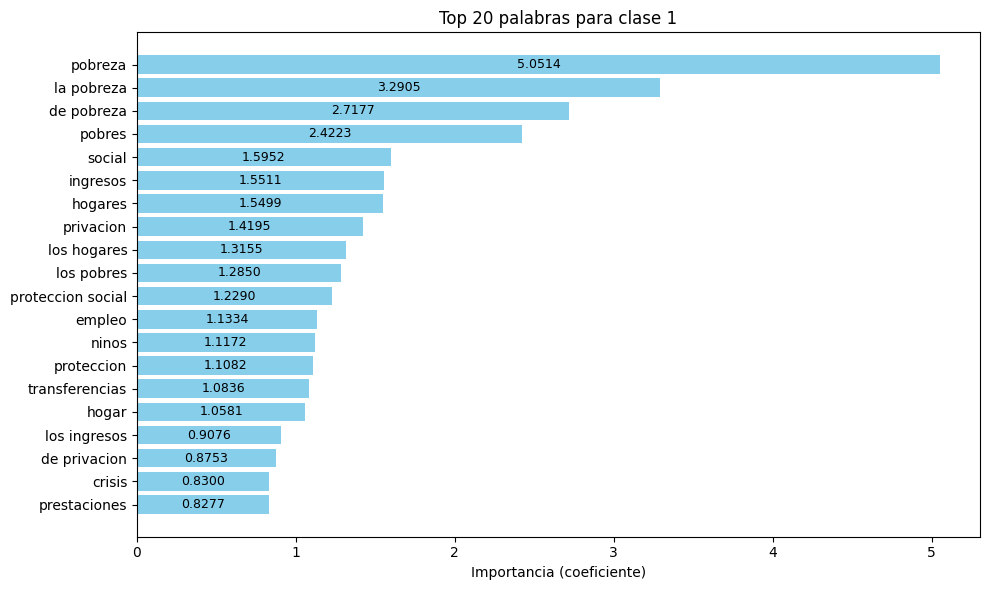

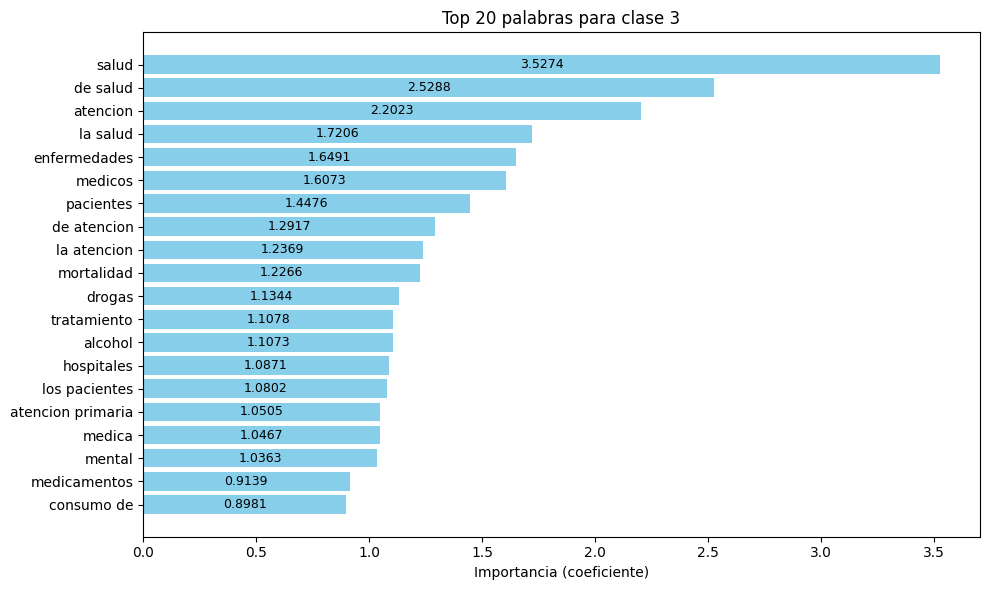

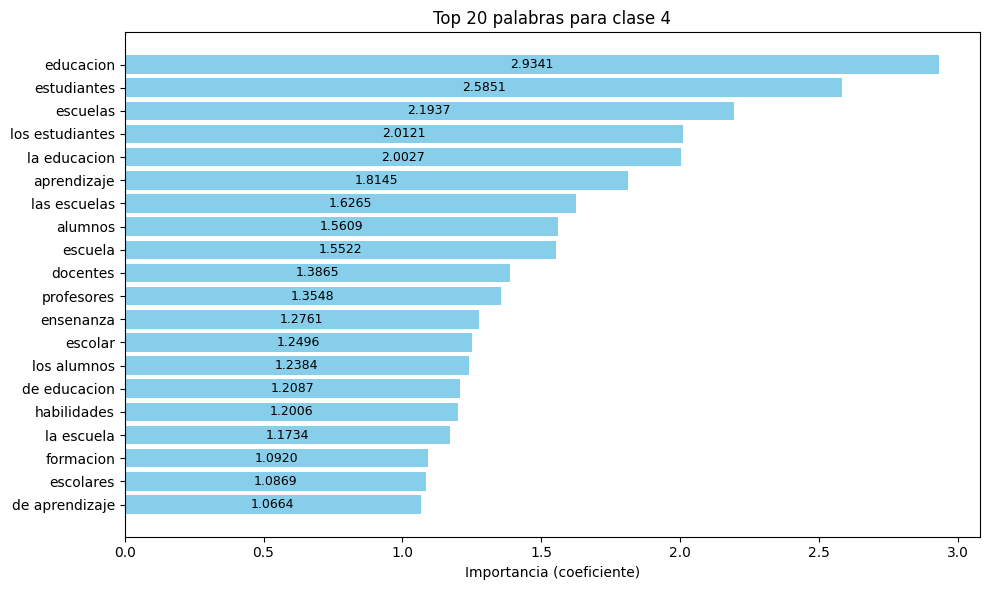

In [ ]:
import numpy as np

# relevancia de palabras
feature_names = vectorizador.get_feature_names_out()
coefs = modelo_rl.coef_

for idx, clase in enumerate(modelo_rl.classes_):
    top_indices = np.argsort(coefs[idx])[-20:]
    top_words = feature_names[top_indices]
    top_values = coefs[idx][top_indices]

    plt.figure(figsize=(10,6))
    bars = plt.barh(top_words, top_values, color="skyblue")
    for bar, val in zip(bars, top_values):
        plt.text(val/2, bar.get_y() + bar.get_height()/2,
                 f"{val:.4f}", ha='center', va='center', fontsize=9, color="black")
    plt.title(f"Top 20 palabras para clase {clase}")
    plt.xlabel("Importancia (coeficiente)")
    plt.tight_layout()
    plt.show()
    print("\n\n")

En el ODS 1, las palabras más destacadas como pobreza, ingresos, hogares, protección social y empleo muestran que las opiniones están fuertemente relacionadas con la necesidad de reducir las carencias económicas y fortalecer los mecanismos de apoyo social. Para la organización, esto significa que debe considerar estrategias que fomenten programas de inclusión económica, incentiven la generación de empleo y consoliden redes de protección social que apoyen a los hogares vulnerables. Esta información es útil porque traduce las percepciones ciudadanas en acciones prioritarias, directamente alineadas con la reducción de la pobreza.

En el ODS 3, los términos identificados como salud, atención, enfermedades, médicos, pacientes, hospitales y tratamiento reflejan que las opiniones se centran en el acceso a servicios médicos de calidad y en la atención de enfermedades. La organización puede aprovechar estos hallazgos para diseñar estrategias orientadas a fortalecer la atención primaria, mejorar la infraestructura hospitalaria y generar campañas de prevención frente a problemas de salud pública, incluyendo el consumo de alcohol y drogas. La utilidad de esta información es que permite dirigir esfuerzos a las áreas más mencionadas por la ciudadanía, asegurando un impacto tangible en el bienestar colectivo.

En el ODS 4, las palabras con mayor peso como educación, estudiantes, escuelas, docentes, aprendizaje y formación evidencian que las opiniones giran en torno al fortalecimiento del sistema educativo y a la calidad de la enseñanza. Esto sugiere que la organización debería plantear estrategias para potenciar la formación docente, mejorar los recursos escolares y promover iniciativas que amplíen las oportunidades de aprendizaje inclusivo. Esta información resulta clave porque conecta la voz de la ciudadanía con acciones concretas en el ámbito educativo, permitiendo diseñar intervenciones alineadas con los desafíos reales de este ODS.

## 5.3. Prediccion de datos

In [ ]:
df_prediccion = pd.read_excel('/content/drive/MyDrive/Proyecto/datos_prueba_proyecto.xlsx', engine='openpyxl')
X_prediccion_vec = vectorizador.transform(df_prediccion["Textos_espanol"])
df_prediccion["labels"] = modelo_rl.predict(X_prediccion_vec)
df_prediccion.to_excel('/content/drive/MyDrive/Proyecto/datos_prediccion_proyecto.xlsx',index=False)

In [ ]:
from sklearn.pipeline import Pipeline
import joblib

pipe = Pipeline([
    ("tfidf", vectorizador),
    ("clf", modelo_rl)
])

# Se guarda el modelo completo que se escogio
joblib.dump(pipe, "modelo_ods.joblib")
print("Pipeline guardado como modelo_ods.joblib")


[3]
Pipeline guardado como modelo_ods.joblib
